In [2]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
mpl.rcParams['font.family']='Times New Roman'
import sys
sys.path.append("..")
import math
from scipy import stats
from scipy.stats import wilcoxon
import seaborn as sns
from statannotations.Annotator import Annotator
from scikit_posthocs import posthoc_dscf,posthoc_mannwhitney
from src.utils import (create_total_df)

sns.set(font_scale=0.8)
sns.set_theme(font="Times New Roman")

In [4]:
def boxplot_hue(dic_of_df,target:str,dic_of_violin_data:dict,tick_names:list,hue_col='cell',save_name=False):
    figsize = (6,4)
    xlabel='Group'
    total_target_values=[]
    total_labels=[]
    total_cell_names=[]
    for cell,violin_data_dic in dic_of_violin_data.items():
        
        df = dic_of_df[cell]
        all_data = df[~((df['cos_sim']>0.8)&(df['cos_sim']<1))][target].values

        """
        pairs=[(tick_names[-2],tick_names[-1])]

        pvalues = [
                stats.mannwhitneyu(data_list[-1],all_data)[-1]
                ]
        """
        target_val = np.append(np.concatenate([lis for lis in violin_data_dic[target]]),all_data)
        labels = np.append(
            np.concatenate([np.repeat(f'{label}', len(lis)) for label,lis in zip(tick_names,violin_data_dic[target]) ]),
            np.repeat('All',len(all_data))
            )
        
        total_target_values.extend(target_val)
        total_labels.extend(labels)
        total_cell_names.extend([cell]*len(target_val))
        
    data = {target: total_target_values,
            xlabel: total_labels,
            hue_col: total_cell_names}

    data_df = pd.DataFrame(data)
    # Seabornのboxplotを使用
    plot_params = {
        'data':data_df,
        'x':xlabel,
        'y':target,
        'hue':hue_col,
        'showfliers':False,
    }
    #pairs = [((f"{tick_name}","HEK293T_XRNwt"),(f"{tick_name}","HEK293T_XRNko")) for tick_name in tick_names]
    #pvalues = [stats.mannwhitneyu(data_list[-1],all_data)[-1]]
    sns.boxplot(**plot_params)
    #annotator = Annotator(ax,pairs,**plot_params)
    #annotator.set_pvalues(pvalues)
    #annotator.annotate()
    plt.xlabel(None)
    plt.tight_layout()
    if save_name:
        plt.savefig(f'./results/imgs/{save_name}')

def boxplot_hue_cell(dic_of_df,target:str,dic_of_violin_data:dict,tick_names:list,hue_col='cell',save_name=False):
    figsize = (6,4)
    _, ax = plt.subplots(1, 1, figsize=figsize)
    xlabel='Group'
    total_target_values=[]
    total_labels=[]
    total_cell_names=[]
    for cell,violin_data_dic in dic_of_violin_data.items():
        
        df = dic_of_df[cell]
        all_data = df[~((df['cos_sim']>0.8)&(df['cos_sim']<1))][target].values

        """
        pairs=[(tick_names[-2],tick_names[-1])]

        pvalues = [
                stats.mannwhitneyu(data_list[-1],all_data)[-1]
                ]
        """
        target_val = np.append(np.concatenate([lis for lis in violin_data_dic[target]]),all_data)
        labels = np.append(
            np.concatenate([np.repeat(f'{label}', len(lis)) for label,lis in zip(tick_names,violin_data_dic[target]) ]),
            np.repeat('All',len(all_data))
            )
        
        total_target_values.extend(target_val)
        total_labels.extend(labels)
        total_cell_names.extend([cell]*len(target_val))
        
    data = {target: total_target_values,
            xlabel: total_labels,
            hue_col: total_cell_names}

    data_df = pd.DataFrame(data)
    # Seabornのboxplotを使用
    plot_params = {
        'data':data_df,
        'x':xlabel,
        'y':target,
        'hue':hue_col,
        'showfliers':False,
    }
    pairs = [((tick_name,"HEK293T_XRNwt"),(tick_name,"HEK293T_XRNko")) for tick_name in tick_names]
    pvalues=[]
    for tick_name in tick_names:
        target_df = data_df[data_df[xlabel]==tick_name]
        _,pval = wilcoxon(target_df[target_df[hue_col]=='HEK293T_XRNwt'][target].values,target_df[target_df[hue_col]=='HEK293T_XRNko'][target].values)
        pvalues.append(pval)
    sns.boxplot(**plot_params)
    annotator = Annotator(ax,pairs,**plot_params)
    annotator.set_pvalues(pvalues)
    annotator.annotate()
    plt.xlabel(None)
    plt.tight_layout()
    if save_name:
        plt.savefig(f'./results/imgs/{save_name}')

def boxplot_alltarget(df:pd.DataFrame,all_targets:list,violin_data_dic:dict,tick_names:list,save_name=None,cell_line=None):
    n_rows = math.ceil(len(all_targets) / 3)
    figsize = (10,4*n_rows)
    fig = plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    xlabel=' ' # CosSim bin

    for i,target in enumerate(all_targets):
        ax = fig.add_subplot(n_rows, 3,i+1)
        data_list = violin_data_dic[target]
        all_data = df[~((df['cos_sim']>0.6)&(df['cos_sim']<1))][target].values

        pairs=[(tick_names[-2],tick_names[-1]),
               (tick_names[-3],tick_names[-1])
              ]

        #pvalues = [stats.mannwhitneyu(data_list[-1],all_data)[-1]]
        test_val = np.append(np.concatenate([lis for lis in violin_data_dic[target][-3:]]),all_data)
        test_labels = np.append(
            np.concatenate([np.repeat(f'{label}', len(lis)) for label,lis in zip(tick_names[-3:],violin_data_dic[target][-3:]) ]),
            np.repeat('All',len(all_data))
            )
        test_df = pd.DataFrame({'groups':test_labels,'values':test_val})
        stat_result=posthoc_dscf(test_df, val_col='values', group_col='groups')
        
        pvalues = stat_result.iloc[-1,:].values[:-1]

        target_val = np.append(np.concatenate([lis for lis in violin_data_dic[target]]),df[target].values)
        labels = np.append(
            np.concatenate([np.repeat(f'{label}', len(lis)) for label,lis in zip(tick_names,violin_data_dic[target]) ]),
            np.repeat('All',len(df))
            )
        
        plot_data = {target: target_val,xlabel: labels}

        data_df = pd.DataFrame(plot_data)
        # Seabornのboxplotを使用
        plot_params = {
            'data':data_df,
            'x':xlabel,
            'y':target,
            'showfliers':False,
        }
        sns.boxplot(**plot_params)
        annotator = Annotator(ax,pairs,**plot_params)
        annotator.set_pvalues(pvalues)
        annotator.annotate()
        ax.set(ylabel=None)
        plt.setp(ax.get_xticklabels(), rotation=30)
        plt.title(target)
    if cell_line:
        plt.suptitle(f'{cell_line}')
    plt.tight_layout()
    if save_name:
        plt.savefig(f'./results/imgs/{save_name}')

def data_binning(df:pd.DataFrame,target_labels:list):
    thresh = np.arange(0,0.8,0.1)
    thresh = np.append(thresh,1.0)
    bin_dic = dict()
    tick_names=[]
    violin_data_dic={label:[] for label in target_labels}
    for i in range(len(thresh)-1):
        upper_th = thresh[i+1]
        lower_th = thresh[i]
        tmp_df = df[(df['cos_sim']>lower_th)&(df['cos_sim']<upper_th)]
        for l in target_labels:
            violin_data_dic[l].append(tmp_df[l].values)
        tmp_dic = tmp_df.describe().loc['mean',target_labels]
        tmp_dic['count'] = tmp_df.describe().loc['count'].values[0]
        bin_dic[f"{lower_th:.1f}-{upper_th:.1f}"] = tmp_dic
        tick_names.append(f"{lower_th:.1f}-{upper_th:.1f}")
    tick_names.append('All')
    bin_dic['All'] = dict(df.describe().loc['mean',target_labels],count=len(df))
    bin_df = pd.DataFrame(bin_dic).T
    return (violin_data_dic,tick_names,bin_df)

def boxplot_hue(dic_of_df,target:str,dic_of_violin_data:dict,tick_names:list,hue_col='cell',save_name=False):
    figsize = (6,4)
    xlabel='Group'
    total_target_values=[]
    total_labels=[]
    total_cell_names=[]
    for cell,violin_data_dic in dic_of_violin_data.items():
        
        df = dic_of_df[cell]
        all_data = df[~((df['cos_sim']>0.8)&(df['cos_sim']<1))][target].values

        """
        pairs=[(tick_names[-2],tick_names[-1])]

        pvalues = [
                stats.mannwhitneyu(data_list[-1],all_data)[-1]
                ]
        """
        target_val = np.append(np.concatenate([lis for lis in violin_data_dic[target]]),all_data)
        labels = np.append(
            np.concatenate([np.repeat(f'{label}', len(lis)) for label,lis in zip(tick_names,violin_data_dic[target]) ]),
            np.repeat('All',len(all_data))
            )
        
        total_target_values.extend(target_val)
        total_labels.extend(labels)
        total_cell_names.extend([cell]*len(target_val))
        
    data = {target: total_target_values,
            xlabel: total_labels,
            hue_col: total_cell_names}

    data_df = pd.DataFrame(data)
    # Seabornのboxplotを使用
    plot_params = {
        'data':data_df,
        'x':xlabel,
        'y':target,
        'hue':hue_col,
        'showfliers':False,
    }
    #pairs = [((f"{tick_name}","HEK293T_XRNwt"),(f"{tick_name}","HEK293T_XRNko")) for tick_name in tick_names]
    #pvalues = [stats.mannwhitneyu(data_list[-1],all_data)[-1]]
    sns.boxplot(**plot_params)
    #annotator = Annotator(ax,pairs,**plot_params)
    #annotator.set_pvalues(pvalues)
    #annotator.annotate()
    plt.xlabel(None)
    plt.tight_layout()
    if save_name:
        plt.savefig(f'./results/imgs/{save_name}')

def boxplot_hue_cell(dic_of_df,target:str,dic_of_violin_data:dict,tick_names:list,hue_col='cell',save_name=False):
    figsize = (6,4)
    _, ax = plt.subplots(1, 1, figsize=figsize)
    xlabel='Group'
    total_target_values=[]
    total_labels=[]
    total_cell_names=[]
    for cell,violin_data_dic in dic_of_violin_data.items():
        
        df = dic_of_df[cell]
        all_data = df[~((df['cos_sim']>0.8)&(df['cos_sim']<1))][target].values

        """
        pairs=[(tick_names[-2],tick_names[-1])]

        pvalues = [
                stats.mannwhitneyu(data_list[-1],all_data)[-1]
                ]
        """
        target_val = np.append(np.concatenate([lis for lis in violin_data_dic[target]]),all_data)
        labels = np.append(
            np.concatenate([np.repeat(f'{label}', len(lis)) for label,lis in zip(tick_names,violin_data_dic[target]) ]),
            np.repeat('All',len(all_data))
            )
        
        total_target_values.extend(target_val)
        total_labels.extend(labels)
        total_cell_names.extend([cell]*len(target_val))
        
    data = {target: total_target_values,
            xlabel: total_labels,
            hue_col: total_cell_names}

    data_df = pd.DataFrame(data)
    # Seabornのboxplotを使用
    plot_params = {
        'data':data_df,
        'x':xlabel,
        'y':target,
        'hue':hue_col,
        'showfliers':False,
    }
    pairs = [((tick_name,"HEK293T_XRNwt"),(tick_name,"HEK293T_XRNko")) for tick_name in tick_names]
    pvalues=[]
    for tick_name in tick_names:
        target_df = data_df[data_df[xlabel]==tick_name]
        _,pval = wilcoxon(target_df[target_df[hue_col]=='HEK293T_XRNwt'][target].values,target_df[target_df[hue_col]=='HEK293T_XRNko'][target].values)
        pvalues.append(pval)
    sns.boxplot(**plot_params)
    annotator = Annotator(ax,pairs,**plot_params)
    annotator.set_pvalues(pvalues)
    annotator.annotate()
    plt.xlabel(None)
    plt.tight_layout()
    if save_name:
        plt.savefig(f'./results/imgs/{save_name}')

def boxplot_targets_topbin(df:pd.DataFrame,all_targets:list,violin_data_dic:dict,tick_names:list,save_name=None,values_name='values',tick_name='tick_name',target_name='target'):
    #n_rows = math.ceil(len(all_targets) / 3)
    figsize = (4,2.5)
    _, ax = plt.subplots(1, 1, figsize=figsize)
    sns.set(font_scale=0.8)
    
    plot_data_df={values_name:[],tick_name:[],target_name:[]}
    stats_pairs = []
    pvalues = []

    for i,target in enumerate(all_targets):
        all_df = df[~((df['cos_sim']>0.7)&(df['cos_sim']<1))]
        ## only take highest bin amd all_data
        values =np.concatenate([violin_data_dic[target][-1],all_df[target].values])
        plot_data_df[values_name].extend(values)
        plot_data_df[tick_name].extend(
            np.concatenate([np.repeat(tick_names[-2], len(violin_data_dic[target][-1])),
            np.repeat('All',len(all_df))]))
        plot_data_df[target_name].extend(np.repeat(target,len(values)))

        ## stats info
        stats_pairs.append(((target,tick_names[-2]),
               (target,tick_names[-1])))
        stats_x = violin_data_dic[target][-1]
        stats_y = all_df[target].values
        pvalues.append(stats.mannwhitneyu(stats_x,stats_y)[-1])        
    data_df = pd.DataFrame(plot_data_df)
    # Seabornのboxplotを使用
    plot_params = {
        'data':data_df,
        'x':target_name,
        'y':values_name,
        'hue':tick_name,
        'showfliers':False,
    }
    sns.boxplot(**plot_params)
    
    annotator = Annotator(ax,stats_pairs,**plot_params)
    annotator.set_pvalues(pvalues)
    annotator.annotate()
    
    #ax.set(ylabel=None)
    plt.setp(ax.get_xticklabels(), rotation=15)
    plt.tight_layout()
    plt.xlabel(None)
    #plt.title(target)
   
    if save_name:
        plt.savefig(f'./results/imgs/{save_name}')

def boxplot_targets_topbin_difax(df:pd.DataFrame,all_targets:list,violin_data_dic:dict,tick_names:list,save_name=None,values_name='values',tick_name='tick_name',target_name='target'):
    #n_rows = math.ceil(len(all_targets) / 3)
    figsize = (4,3)
    sns.set(font_scale=0.8)
    #fig = plt.figure(figsize=figsize)
    
    for i,target in enumerate(all_targets):
        ax = plt.subplot(1,len(all_targets),i+1)
        plot_data_df={values_name:[],tick_name:[],target_name:[]}
        all_df = df[~((df['cos_sim']>0.7)&(df['cos_sim']<1))]
        ## only take highest bin amd all_data
        values =np.concatenate([violin_data_dic[target][-1],all_df[target].values])
        plot_data_df[values_name].extend(values)
        plot_data_df[tick_name].extend(
            np.concatenate([np.repeat(tick_names[-2], len(violin_data_dic[target][-1])),
            np.repeat('All',len(all_df))]))
        plot_data_df[target_name].extend(np.repeat(target,len(values)))

        ## stats info
        stats_pairs=[(tick_names[-2],tick_names[-1])]
        stats_x = violin_data_dic[target][-1]
        stats_y = all_df[target].values
        pvalues=[stats.mannwhitneyu(stats_x,stats_y)[-1]]
        data_df = pd.DataFrame(plot_data_df)
        # Seabornのboxplotを使用
        plot_params = {
            'data':data_df,
            'x':tick_name,
            'y':values_name,
            #'hue':tick_name,
            'showfliers':False,
        }
        sns.boxplot(**plot_params)
        plt.xlabel(target)
        plt.ylabel(None)
        plt.tight_layout()
        annotator = Annotator(ax,stats_pairs,**plot_params)
        annotator.set_pvalues(pvalues)
        annotator.annotate()
    
    #ax.set(ylabel=None)
    #plt.setp(ax.get_xticklabels(), rotation=30)
    plt.tight_layout()
    #plt.title(target)
   
    if save_name:
        plt.savefig(f'./results/imgs/{save_name}')

def data_binning(df:pd.DataFrame,target_labels:list):
    thresh = np.arange(0,0.8,0.1)
    thresh = np.append(thresh,1.0)
    bin_dic = dict()
    tick_names=[]
    violin_data_dic={label:[] for label in target_labels}
    for i in range(len(thresh)-1):
        upper_th = thresh[i+1]
        lower_th = thresh[i]
        tmp_df = df[(df['cos_sim']>lower_th)&(df['cos_sim']<upper_th)]
        for l in target_labels:
            violin_data_dic[l].append(tmp_df[l].values)
        tmp_dic = tmp_df.describe().loc['mean',target_labels]
        tmp_dic['count'] = tmp_df.describe().loc['count'].values[0]
        bin_dic[f"{lower_th:.1f}-{upper_th:.1f}"] = tmp_dic
        tick_names.append(f"{lower_th:.1f}-{upper_th:.1f}")
    tick_names.append('All')
    bin_dic['All'] = dict(df.describe().loc['mean',target_labels],count=len(df))
    bin_df = pd.DataFrame(bin_dic).T
    return (violin_data_dic,tick_names,bin_df)


def concat_df(tot_df:pd.DataFrame,ribo:pd.DataFrame,rna:pd.DataFrame):
    remover=lambda x:x.split('.')[0]
    ribo['ENST_ID']=ribo['transcript_id'].apply(remover)
    rna['ENST_ID']=rna['transcript_id'].apply(remover)
    df_concat=pd.merge(tot_df,ribo,on='ENST_ID',how='inner')
    df_concat=pd.merge(df_concat,rna,on='ENST_ID',how='inner')
    df_concat=df_concat[(df_concat['cds_len']!=0)&(df_concat['TPM_rna']!=0)]
    df_concat['TE'] = df_concat['TPM_ribo']/df_concat['TPM_rna']

    return df_concat

In [5]:

#seq_df = pd.read_csv('/home/ksuga/whole_mrna_predictor/UTR_PairPred/data/human/gencode44_utr_gene_unique_cdhit09.csv')
seq_df = pd.read_csv('../data/human/gencode44_utr_gene_unique_cdhit09_mfe.csv')
remover= lambda x:x.split(".")[0]

#cl_dir = "/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/runs/contrastive_learning_10fold_shuffle_seed0"
cl_dir = "/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/runs/contrastive_learning_10fold_rinalmo_whole_ave_seed1"
tot_df_cl = create_total_df(cl_dir,seq_df)
tot_df_cl=tot_df_cl.drop("ENST_ID",axis=1).rename(columns={"ENST_ID_PRE":"ENST_ID"})


## Length,MFE basic features

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

5UTR_tail_mfe_0.7-1.0 vs. 5UTR_tail_mfe_All: Custom statistical test, P_val:5.650e-03
5UTR_head_mfe_0.7-1.0 vs. 5UTR_head_mfe_All: Custom statistical test, P_val:9.021e-01
5UTR_tail_cds_mfe_0.7-1.0 vs. 5UTR_tail_cds_mfe_All: Custom statistical test, P_val:4.658e-03


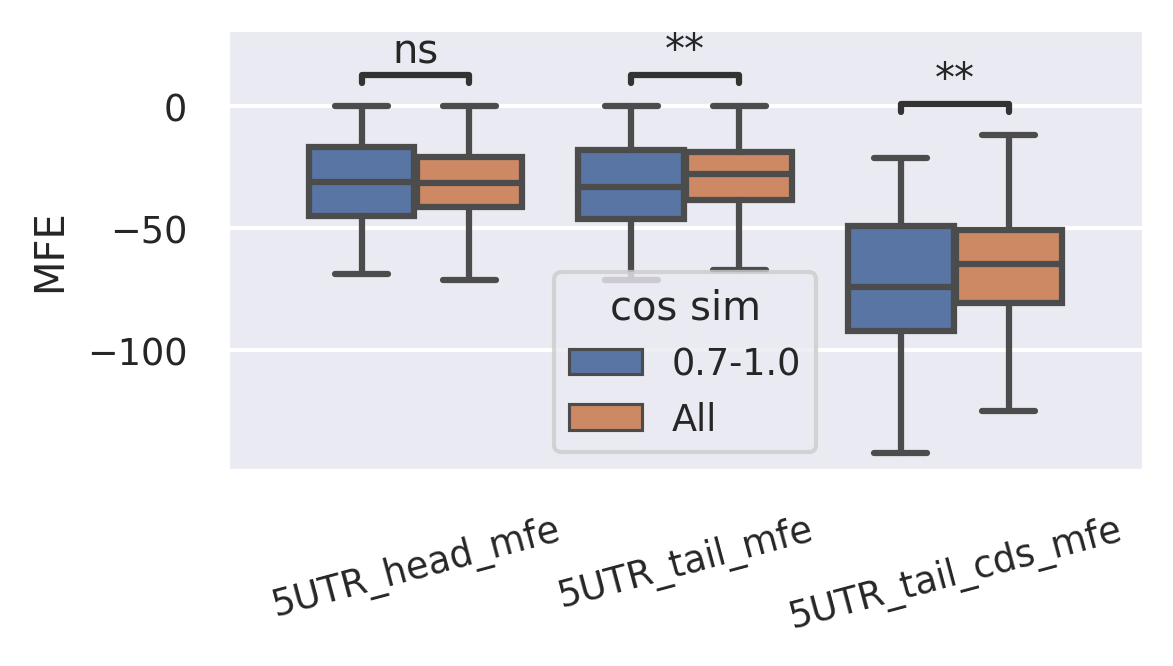

In [ ]:
targets = ['5UTR_head_mfe','5UTR_tail_mfe','5UTR_tail_cds_mfe']
#targets= ['3UTR_head_cds_mfe','3UTR_head_mfe','3UTR_tail_mfe']
violin_data_dic,tick_names,bin_df = data_binning(tot_df_cl,target_labels=targets)

boxplot_targets_topbin(tot_df_cl,all_targets=targets,violin_data_dic=violin_data_dic,tick_names=tick_names,save_name='boxplot_mfe_utr5_all_in_one',values_name='MFE',tick_name='cos sim',target_name=' ')
#boxplot_targets_topbin_difax(tot_df_cl,all_targets=targets,violin_data_dic=violin_data_dic,tick_names=tick_names,save_name='boxplot_length_eachax',values_name='length',tick_name='cos sim',target_name=' ')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

5UTR_tail_mfe_0.7-1.0 vs. 5UTR_tail_mfe_All: Custom statistical test, P_val:5.650e-03
5UTR_head_mfe_0.7-1.0 vs. 5UTR_head_mfe_All: Custom statistical test, P_val:9.021e-01
5UTR_tail_cds_mfe_0.7-1.0 vs. 5UTR_tail_cds_mfe_All: Custom statistical test, P_val:4.658e-03


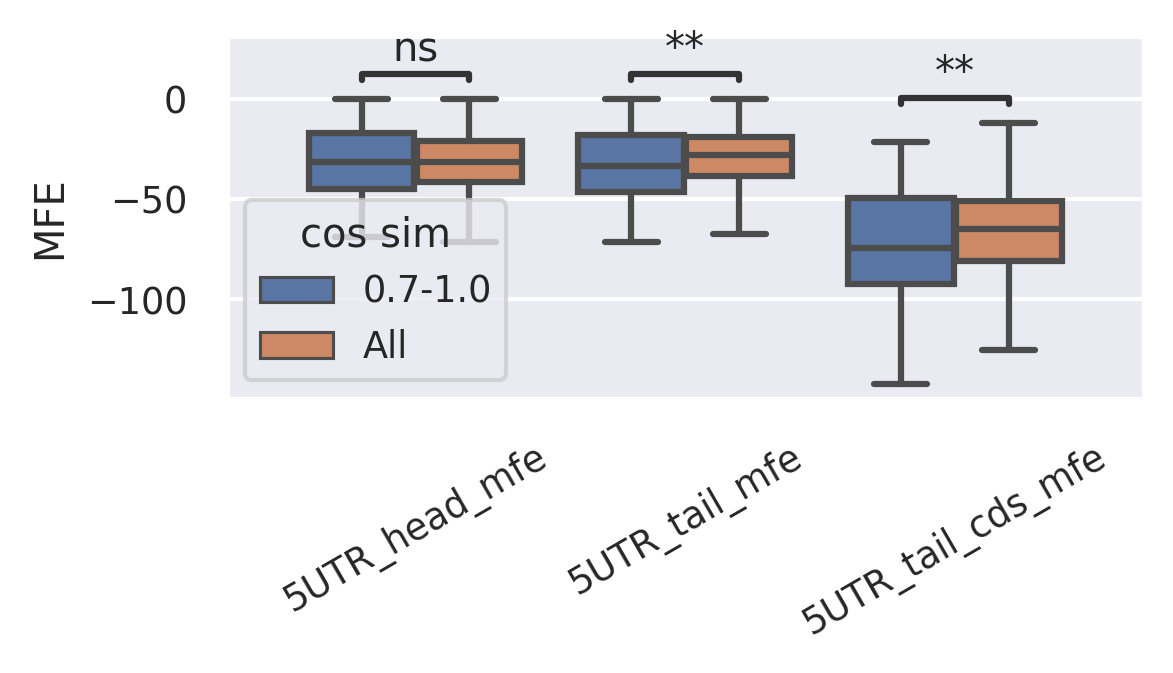

In [124]:
targets = ['5UTR_head_mfe','5UTR_tail_mfe','5UTR_tail_cds_mfe']
violin_data_dic,tick_names,bin_df = data_binning(tot_df_cl,target_labels=targets)

boxplot_targets_topbin(tot_df_cl,all_targets=targets,violin_data_dic=violin_data_dic,tick_names=tick_names,save_name='boxplot_mfe_utr5_all_in_one',values_name='MFE',tick_name='cos sim',target_name=' ')
#boxplot_targets_topbin_difax(tot_df_cl,all_targets=targets,violin_data_dic=violin_data_dic,tick_names=tick_names,save_name='boxplot_length_eachax',values_name='length',tick_name='cos sim',target_name=' ')

,utr5,utr3,label,pred,correct,logits,cos_sim,ENST_ID,GENE,5UTR,...,total_len,5UTR_len,CDS_len,3UTR_len,5UTR_head_mfe,5UTR_tail_mfe,5UTR_tail_cds_mfe,3UTR_head_cds_mfe,3UTR_head_mfe,3UTR_tail_mfe
293,9257,9257,1,True,True,0.705522,0.873735,ENST00000528841,BRSK2,GGCUCGGCUCGGCUGCGCGGCCGCUGACGGGCGUGCGCUGGGGGCG...,...,4528,351,2211,1966,-68.900002,-56.700001,-96.199997,-245.300003,-197.000000,-173.500000
296,3716,3716,1,True,True,0.696336,0.829912,ENST00000618052,H3C7,AGUUGUGACCAUUGCUUGAAACCCAUUCCU,...,494,30,411,53,0.000000,0.000000,-44.799999,-48.200001,-13.000000,-13.000000
299,3520,3520,1,True,True,0.695916,0.827926,ENST00000328345,POU3F2,AGAGAGCUGGAGAGAGCAGGGAGAGGGGGGAGCGCCGAGCUAGUCA...,...,4885,300,1332,3253,-14.000000,-33.000000,-77.699997,-185.100006,-134.000000,-115.000000
405,1384,1384,1,True,True,0.694372,0.820638,ENST00000293441,SHANK1,AGAGACAGCGAGAGCGAGAGAGCGAGAAGGGUGGCAGAGGAGGCGC...,...,9636,440,6486,2710,-21.200001,-58.299999,-93.500000,-275.200012,-234.100006,-156.190002
28,7625,7625,1,True,True,0.694133,0.819514,ENST00000394166,NR2F2,GAGAAGCCACUUCUGCCAGCCCCGGCGCCUAUAAAUCGCAUUCCCU...,...,5287,1406,1245,2636,-11.500000,-40.700001,-92.300003,-125.400002,-102.000000,-125.900002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,3689,3689,1,False,False,0.396502,-0.420062,ENST00000567435,UBL7,GGCGCUGGGGCCCUGGGCAGCGCGGGCUCGAUGUGUGUCAGCCAAG...,...,1720,464,1143,113,-39.400002,-25.400000,-64.099998,-79.000000,-30.700001,-30.700001
784,6853,6853,1,False,False,0.395291,-0.425126,ENST00000306324,HOXD4,AGUUGACAGCAAGUAGGAGGGCCCUAUGGAAGGAGAAAAAAAGACA...,...,1136,84,768,284,-13.600000,-13.600000,-43.400002,-153.500000,-118.400002,-118.400002
1622,7255,7255,1,False,False,0.394273,-0.429387,ENST00000337014,HEXD,GUCGGGCCAGGCCCCGCCCCAUCAGCCCCAGUCCCGCCCACUCCAU...,...,2285,474,1758,53,-21.200001,-38.200001,-66.800003,-44.700001,-13.600000,-13.600000
458,9617,9617,1,False,False,0.392457,-0.436998,ENST00000334134,FGF3,AGAGCCAGGAGGGCUUUCGGGGGCGUGGGGCGCGCUGCGGAGCGGA...,...,1540,483,720,337,-46.900002,-45.200001,-115.500000,-188.699997,-137.300003,-137.300003


## GC rate 

In [ ]:
tot_df_cl['GC_rate_5UTR'] = tot_df_cl['5UTR'].apply(lambda x: (x.count('G')+x.count('C'))/len(x))
tot_df_cl['GC_rate_3UTR'] = tot_df_cl['3UTR'].apply(lambda x: (x.count('G')+x.count('C'))/len(x))

In [18]:
tot_df_cl[
    [
        "cos_sim",
        "5UTR_head_mfe",
        "5UTR_tail_mfe",
        "5UTR_tail_cds_mfe",
        "GC_rate_5UTR",
        "GC_rate_3UTR",
    ]
].corr()

,cos_sim,5UTR_head_mfe,5UTR_tail_mfe,5UTR_tail_cds_mfe,GC_rate_5UTR,GC_rate_3UTR
cos_sim,1.000000,-0.035061,-0.037148,-0.026460,-0.023388,0.065187
5UTR_head_mfe,-0.035061,1.000000,0.664463,0.524785,-0.524148,-0.103861
5UTR_tail_mfe,-0.037148,0.664463,1.000000,0.828689,-0.613439,-0.189936
5UTR_tail_cds_mfe,-0.026460,0.524785,0.828689,1.000000,-0.674916,-0.309726
GC_rate_5UTR,-0.023388,-0.524148,-0.613439,-0.674916,1.000000,0.290860
GC_rate_3UTR,0.065187,-0.103861,-0.189936,-0.309726,0.290860,1.000000


## Gene Ontology graph

In [3]:
go_parent_df = pd.read_csv('/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/analysis/metascape_rinalmo_cossim_0.7-1.0_genes/Enrichment_GO/GO_membership_parent.csv')
go_child_df = pd.read_csv('/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/analysis/metascape_rinalmo_cossim_0.7-1.0_genes/Enrichment_GO/GO_membership.csv')

In [4]:
go_parent_df

,_MEMBER_GENE,_LogP_GENE,GO,Description,_PATTERN_,_RANK_,CHILD_GO_GENE
0,1,-10.007542,GO:0032502,developmental process,M1,1,GO:0060322 head development
1,1,-8.559450,GO:0009987,cellular process,M1,1,GO:0034728 nucleosome organization
2,1,-6.496842,GO:0040007,growth,M1,1,GO:0040007 growth
3,1,-5.486987,GO:0048518,positive regulation of biological process,M1,1,GO:0051897 positive regulation of phosphatidyl...
4,1,-4.998972,GO:0050789,regulation of biological process,M1,1,GO:0050804 modulation of chemical synaptic tra...
5,1,-4.687625,GO:0051179,localization,M1,1,GO:0046903 secretion
6,1,-4.287335,GO:0050896,response to stimulus,M1,1,GO:0051896 regulation of phosphatidylinositol ...
7,1,-4.021985,GO:0065007,biological regulation,M1,1,GO:0050878 regulation of body fluid levels
8,1,-3.695120,GO:0048519,negative regulation of biological process,M1,1,GO:0045912 negative regulation of carbohydrate...
9,1,-3.570212,GO:0032501,multicellular organismal process,M1,1,GO:0007586 digestion


In [5]:
go_child_df_selected = go_child_df[go_child_df['GO'].str.contains('GO:')].sort_values('_LogP_GENE',ascending=False).iloc[-5:]
go_child_df_selected['Description'].values[2]= 'plasma membrane bounded \n cell projection morphogenesis'

In [7]:
go_child_df_selected

,_MEMBER_GENE,_LogP_GENE,GO,Description,_PATTERN_,_RANK_,GiniIndex
236,1,-9.0,GO:0045165,cell fate commitment,M1,1,0
486,1,-9.1,GO:0048858,cell projection morphogenesis,M1,1,0
516,1,-9.1,GO:0120039,plasma membrane bounded \n cell projection mor...,M1,1,0
319,1,-9.2,GO:0048812,neuron projection morphogenesis,M1,1,0
386,1,-10.0,GO:0060322,head development,M1,1,0


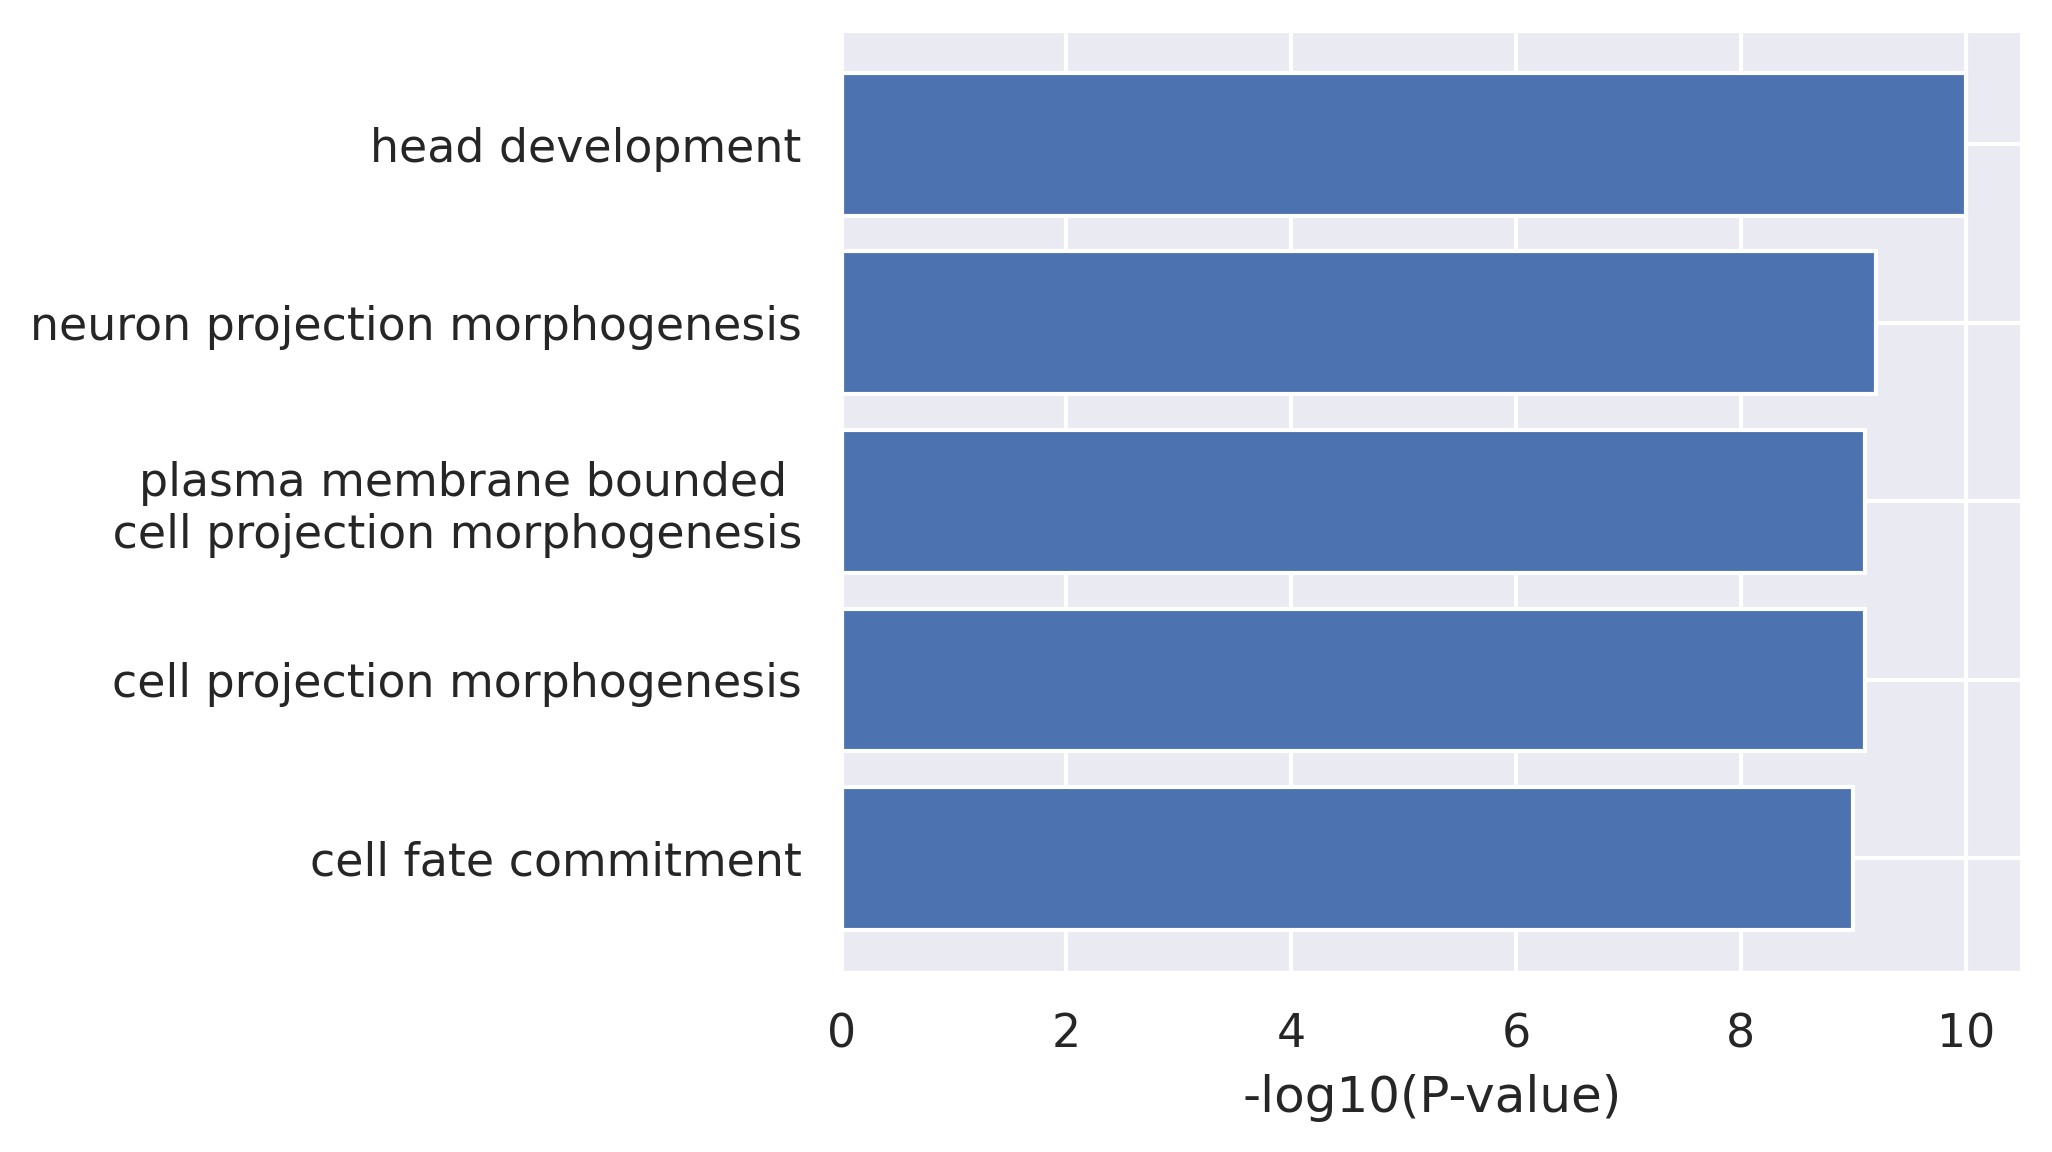

In [8]:
labels = go_child_df_selected['Description']
sns.set()
plt.figure(figsize=(7,4))
plt.barh(y=np.arange(len(go_child_df_selected)),width= -go_child_df_selected['_LogP_GENE'],tick_label=labels)
plt.xlabel('-log10(P-value)')
plt.tight_layout()

#plt.savefig('./results/imgs/barh_metascape_top5_rinalmo_cossim_0.7-1.0.png')

## Base pair probability

In [2]:
seq_df = pd.read_csv('/home/ksuga/whole_mrna_predictor/UTR_PairPred/data/human/gencode44_utr_gene_unique_cdhit09.csv',index_col=0)
out_path = '/home/ksuga/whole_mrna_predictor/UTR_PairPred/tmp_pair.txt'
cl_dir = "/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/runs/contrastive_learning_10fold_rinalmo_whole_ave_seed1"
tot_df_cl = create_total_df(cl_dir,seq_df)
tot_df_cl=tot_df_cl.drop("ENST_ID",axis=1).rename(columns={"ENST_ID_PRE":"ENST_ID"})

In [6]:
high_df = tot_df_cl[tot_df_cl['cos_sim']>0.7]
high_df

,utr5,utr3,label,pred,correct,logits,cos_sim,ENST_ID,GENE,5UTR,CDS,3UTR,total_len,5UTR_len,CDS_len,3UTR_len
293,9257,9257,1,True,True,0.705522,0.873735,ENST00000528841,BRSK2,GGCUCGGCUCGGCUGCGCGGCCGCUGACGGGCGUGCGCUGGGGGCG...,AUGACAUCGACGGGGAAGGACGGCGGCGCGCAGCACGCGCAGUAUG...,ACACACUAGCCCCCCCCCCCAGCACAGCACUGACAGCGGCUGCCUC...,4528,351,2211,1966
296,3716,3716,1,True,True,0.696336,0.829912,ENST00000618052,H3C7,AGUUGUGACCAUUGCUUGAAACCCAUUCCU,AUGGCACGCACGAAGCAAACAGCUCGUAAGUCCACUGGCGGCAAAG...,GUUGUACUGAGGGUGUGCGCCAACUUAAACCAAAGGCUCUUUUCAG...,494,30,411,53
299,3520,3520,1,True,True,0.695916,0.827926,ENST00000328345,POU3F2,AGAGAGCUGGAGAGAGCAGGGAGAGGGGGGAGCGCCGAGCUAGUCA...,AUGGCGACCGCAGCGUCUAACCACUACAGCCUGCUCACCUCCAGCG...,ACUCGAGCUGGGGGAGGGGCAGAGCGCGGGGCUCCCCCUCCCCUUC...,4885,300,1332,3253
405,1384,1384,1,True,True,0.694372,0.820638,ENST00000293441,SHANK1,AGAGACAGCGAGAGCGAGAGAGCGAGAAGGGUGGCAGAGGAGGCGC...,AUGACCCACAGCCCCGCGACAAGCGAGGACGAGGAACGCCACAGUG...,UGGCUGGCCUGGACGGACCAGCCCCGUCCACAGAACUCUUGAGCCU...,9636,440,6486,2710
28,7625,7625,1,True,True,0.694133,0.819514,ENST00000394166,NR2F2,GAGAAGCCACUUCUGCCAGCCCCGGCGCCUAUAAAUCGCAUUCCCU...,AUGGCAAUGGUAGUCAGCACGUGGCGCGACCCCCAGGACGAGGUGC...,AUAAAUAAAAUAAGAAGGGGGAGUGAAACAGAGAAAGAAAAGGCAA...,5287,1406,1245,2636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,13113,13113,1,True,True,0.668744,0.702508,ENST00000393409,PLXNA1,AUUCAUGCUGGGCAUCGGCUGCGCGGCCACGCAGCGGAGCCCGGGC...,AUGCCGCUGCCACCGCGGAGCCUGCAGGUGCUCCUGCUGCUGCUGC...,GCCCCAGCUGUGAUCAUCCAGCAUGAUGCAGCGUGAGGACAGCUGA...,9309,246,5691,3372
990,12596,12596,1,True,True,0.668717,0.702388,ENST00000683543,KMT2D,GCCGCUCCGCUCCAACACAAAAUAGGGCCGCCUCUUCUCCUUUCUC...,AUGGACAGCCAGAAGCUGGCUGGUGAGGAUAAAGAUUCAGAACCGG...,GAAGCUUUGAGGCUACCAGGCAGGGGAGUCCCCCUACCCACAACCU...,20686,1219,16662,2805
961,10732,10732,1,True,True,0.668716,0.702385,ENST00000240691,TAS2R9,GUCUAAGAGGCAGACAGAUACAUUGUUCUUCACUGGUCAGCUGAAA...,AUGCCAAGUGCAAUAGAGGCAAUAUAUAUUAUUUUAAUUGCUGGUG...,AGACCCCUAAAGAGUAUCCUGACUACAAGGAUGAAAGAAAUCA,1075,93,939,43
644,16572,16572,1,True,True,0.668597,0.701846,ENST00000540986,CIAO3,AUCGGGCCGUCUCAGGUGGGCCGGCCUGGGCGGGCGGGGUCGAGGC...,AUGGCGGCACCCAGUCAGCAGAGGCUGGUUGUAGUUUCGGUCUCAC...,GGGCUGCAGGACCAGGACUCCCAGGAGGCCGUGUCCAUGUGUGACA...,3212,1436,1125,651


In [8]:
rec = tot_df_cl.iloc[2]
whole_seq = rec['5UTR']+rec['CDS']+rec['3UTR']
seq_len = len(whole_seq)

#cmd = ['echo',f'{whole_seq}','|','./LinearPartition/linearpartition']
cmd = f'echo {whole_seq} | ../LinearPartition/linearpartition -r part_out.txt'
subprocess.run(cmd,shell=True)

plot_cmd = f'cat part_out.txt | ../LinearPartition/draw_heatmap {seq_len+1}'
subprocess.run(plot_cmd,shell=True)

AGAGAGCUGGAGAGAGCAGGGAGAGGGGGGAGCGCCGAGCUAGUCAGAGAGUGAGCGAGAGCGAGAAGGAGGGAGAGGAGGAGAAAGAGAGCGAGGGCGGGCGGGAGGCGGCGGCGGCGGCAGCAGCAGCAGUAAUAGCAGGAGCAGCAACAGAAGGCGUCGGAGCGGGCGUCGGAGCUGCCCGCUGUGGGAGAGAGAGGAGACAGAAAGAGCGAGCGAGGAGAGGGAGCCCGAGGCGAAAAAGUAACUGUCAAAUGCGCGGCUCCUUUAACCGGAGCGCUCAGUCCGGCUCCGAGAGUCAUGGCGACCGCAGCGUCUAACCACUACAGCCUGCUCACCUCCAGCGCCUCCAUCGUGCACGCCGAGCCGCCCGGCGGCAUGCAGCAGGGCGCGGGGGGCUACCGCGAAGCGCAGAGCCUGGUGCAGGGCGACUACGGCGCUCUGCAGAGCAACGGACACCCGCUCAGCCACGCUCACCAGUGGAUCACCGCGCUGUCCCACGGCGGCGGCGGCGGGGGCGGUGGCGGCGGCGGGGGGGGCGGGGGCGGCGGCGGGGGCGGCGGCGACGGCUCCCCGUGGUCCACCAGCCCCCUGGGCCAGCCGGACAUCAAGCCCUCGGUGGUGGUGCAGCAGGGCGGCCGCGGAGACGAGCUGCACGGGCCAGGCGCCCUGCAGCAGCAGCAUCAGCAGCAGCAACAGCAACAGCAGCAGCAACAGCAGCAACAGCAGCAGCAGCAGCAGCAACAGCGGCCGCCGCAUCUGGUGCACCACGCCGCUAACCACCACCCGGGACCCGGGGCAUGGCGGAGCGCGGCGGCUGCAGCGCACCUCCCACCCUCCAUGGGAGCGUCCAACGGCGGCUUGCUCUACUCGCAGCCCAGCUUCACGGUGAACGGCAUGCUGGGCGCCGGCGGGCAGCCGGCCGGUCUGCACCACCACGGCCUGCGGGACGCGCACGACGAGCCACACCAUGCCGACCACCACCCGCACCCGCACUCGC

Log Partition Coefficient: 660.12065


Outputing base pairing probability matrix to part_out.txt...
Done!


CompletedProcess(args='cat part_out.txt | ../LinearPartition/draw_heatmap 4886', returncode=0)

## Sequence motif

In [1]:
import logomaker

In [46]:
crp_df = -logomaker.get_example_matrix('crp_energy_matrix',
                                        print_description=False)

In [60]:
import pandas as pd
idx = ['A','C','G','U']
background = np.array([0.20060,0.29530,0.30340,0.20070])
ex = pd.read_table('/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/analysis/xstreme/rinalmo_5utr/motif1.tsv',header=None)
ex.columns = idx
bits = np.log2(ex/background)

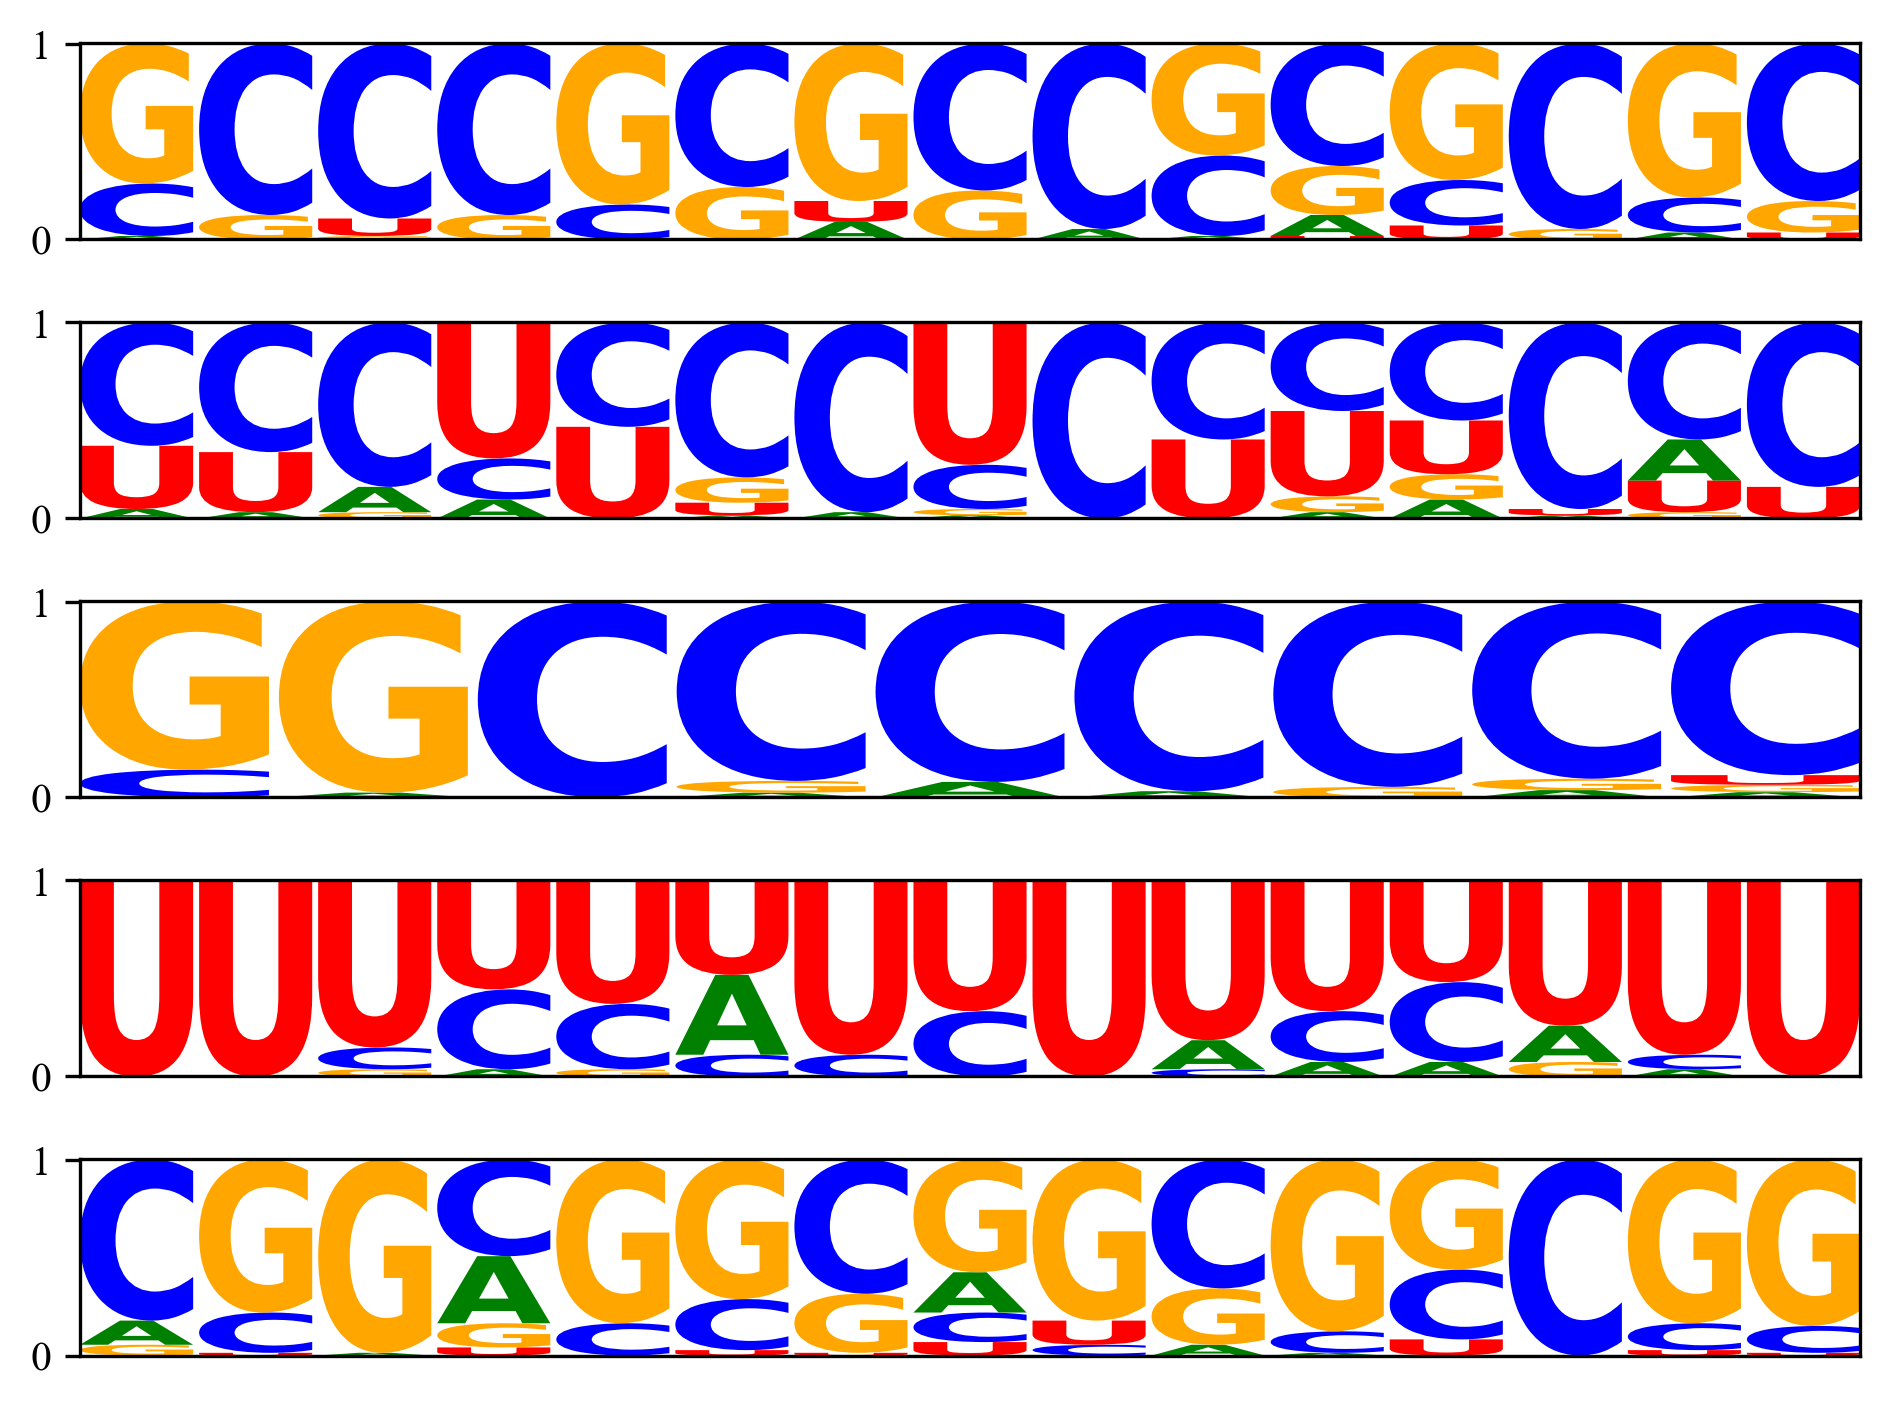

In [78]:
motif_num=5
idx = ['A','C','G','U']
fig = plt.figure()
for i in range(motif_num):
    ex = pd.read_table(f'/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/analysis/xstreme/rinalmo_5utr/motif{i+1}.tsv',header=None)
    ex.columns = idx
    ax = fig.add_subplot(motif_num,1,i+1)
    tmp_logo=logomaker.Logo(ex,
                shade_below=.5,
                fade_below=.5,
                ax=ax)
    tmp_logo.ax.set_yticks([0,1])
    tmp_logo.ax.set_yticklabels([0,1])
    tmp_logo.ax.set_xticks([])
    tmp_logo.ax.set_xticklabels([])
    
    #plt.tight_layout()
plt.tight_layout()
plt.savefig('/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/analysis/xstreme/rinalmo_5utr/utr5_top5_motifs.png')

## 3UTR motif

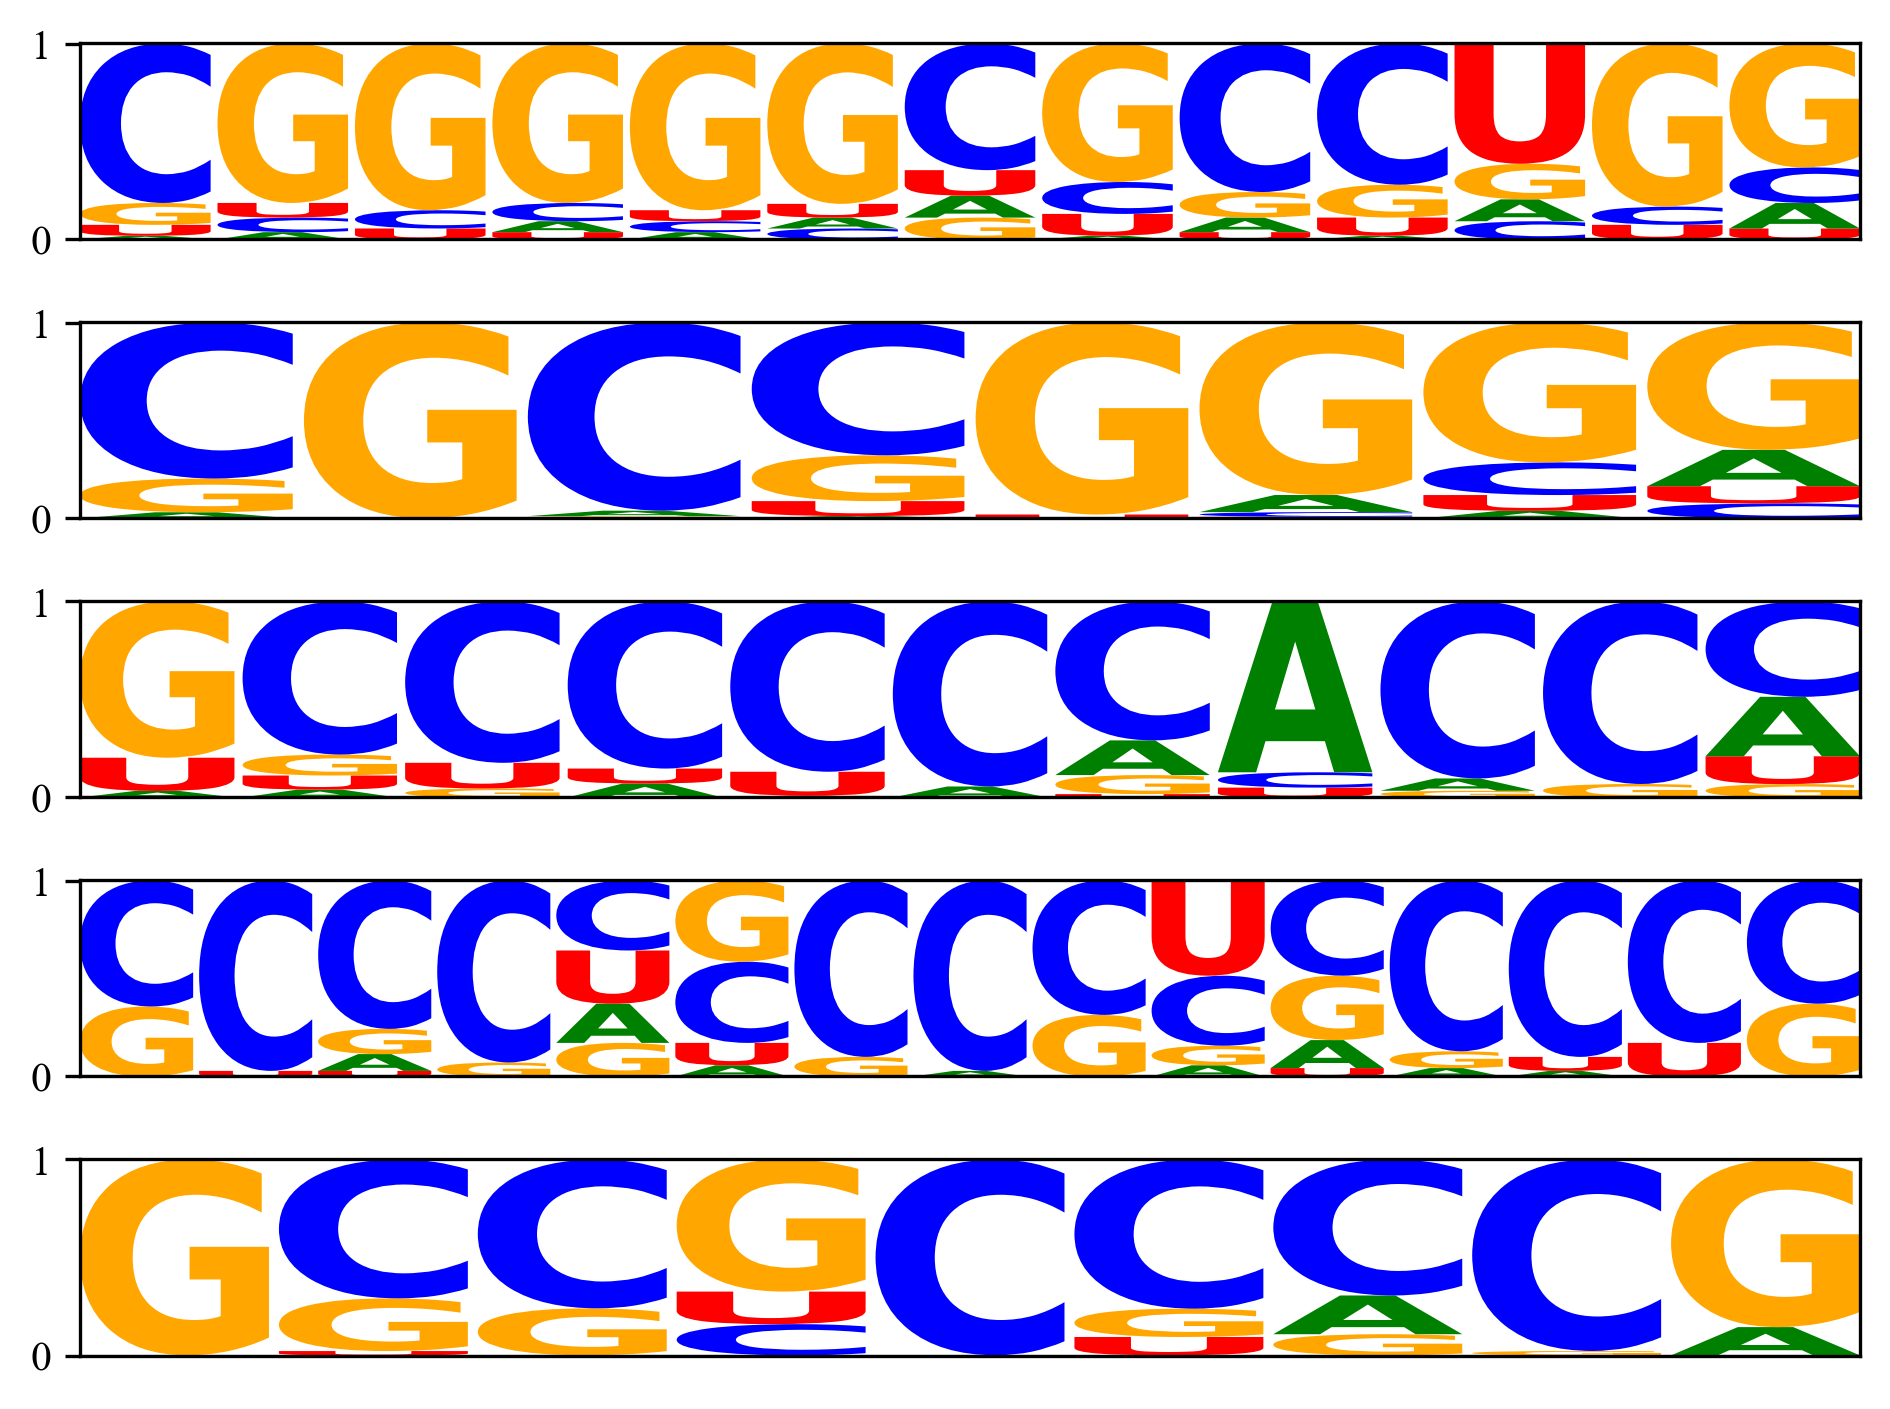

In [79]:
motif_num=5
idx = ['A','C','G','U']
fig = plt.figure()
for i in range(motif_num):
    ex = pd.read_table(f'/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/analysis/xstreme/rinalmo_3utr/motif{i+1}.tsv',header=None)
    ex.columns = idx
    ax = fig.add_subplot(motif_num,1,i+1)
    tmp_logo=logomaker.Logo(ex,
                shade_below=.5,
                fade_below=.5,
                ax=ax)
    tmp_logo.ax.set_yticks([0,1])
    tmp_logo.ax.set_yticklabels([0,1])
    tmp_logo.ax.set_xticks([])
    tmp_logo.ax.set_xticklabels([])
    
    #plt.tight_layout()
plt.tight_layout()
plt.savefig('/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/analysis/xstreme/rinalmo_3utr/utr3_top5_motifs.png')